# Analyzing Seattle AirBnb Data

### Table of contents

<ul>
    <li><a href='#intro'>Introduction</a></li>
    <li><a href='#b_understanding'>Business Understanding</a></li>
    <li><a href='#d_understanding'>Data Understanding</a></li>
    <li><a href='#prepare'>Prepare Data</a></li>
    <li><a href='#evaluate'>Evaluate the result</a></li>
</ul>

<a id='intro'></a>
## Introduction

> For this project I picked a Seattle AirBnb dataset. 
> The following Airbnb activity is included in this Seattle dataset:
> - Listings, including full descriptions and average review score
> - Reviews, including unique id for each reviewer and detailed comments
> - Calendar, including listing id and the price and availability for that day

> This data will be explored using the Cross-Industry Standard Process for Data Mining (CRISP-DM)

<a id='b_understanding'></a>
## Business Understanding

> These are the questions I'm interested in tackling:
> 1. What is the average price per months and days of the week?
> 2. Which neighborhood is the most expensive one?
> 3. What property types are most popular?

<a id='d_understanding'></a>
## Data Understanding

In [325]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import glob
import os


plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14

# Base color
base_color = sns.color_palette()[0]

In [326]:
# import datasets
reviews_df = pd.read_csv('datasets/reviews.csv')
listings_df = pd.read_csv('datasets/listings.csv')
calendar_df = pd.read_csv('datasets/calendar.csv')

In [327]:
# set the options to get better view on data
pd.set_option("display.max_columns", 100)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 100)

#### Data Assessment

In [328]:
# print dimensions of each dataset
print('Reviews dataset shape:', reviews_df.shape)
print('Listings dataset shape:', listings_df.shape)
print('Calendar dataset shape:', calendar_df.shape)

Reviews dataset shape: (84849, 6)
Listings dataset shape: (3818, 92)
Calendar dataset shape: (1393570, 4)


In [329]:
# print first five rows of reviews dataset
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


I do not see any values or features in 'reviews' dataset which could answer some interesting bussines related question, so I decided not to use this dataset in further process.

In [330]:
# print first five rows of calendar dataset
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [331]:
# print sum of null/missing values for each column
calendar_df.isnull().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

In [332]:
# show dataset info
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [333]:
# check data type
calendar_df.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

In [334]:
# Check if number of missing values in price feature is the same as number of 'f' availability
calendar_df.price.isnull().sum() == calendar_df[calendar_df.available == 'f'].shape[0]

True

In [335]:
# check for duplicates
calendar_df.duplicated().sum()

0

In [336]:
calendar_df.price.value_counts()

$150.00    36646
$100.00    31755
$75.00     29820
$125.00    27538
$65.00     26415
           ...  
$751.00        1
$759.00        1
$12.00         1
$685.00        1
$554.00        1
Name: price, Length: 669, dtype: int64

In [337]:
# check if all prices exclude cents
calendar_df.price[calendar_df.price == calendar_df.price.str.endswith('.00')].shape[0]

0

###### These are some data quality issues regarding calendar dataset:
> 1. Convert date feature to datetime
> 2. Convert price feature to int and drop decimal points
> 3. Drop rows with missing price feature values (we've seen that number of missing values in price feature is the same as number of times where the property was not availability)


In [338]:
# print first five rows of listings dataset
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [339]:
# showing all columns
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleanin

In [340]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [341]:
# print sum of null/missing values for each column
listings_df.isnull().sum()

id                                     0
listing_url                            0
scrape_id                              0
last_scraped                           0
name                                   0
summary                              177
space                                569
description                            0
experiences_offered                    0
neighborhood_overview               1032
notes                               1606
transit                              934
thumbnail_url                        320
medium_url                           320
picture_url                            0
xl_picture_url                       320
host_id                                0
host_url                               0
host_name                              2
host_since                             2
host_location                          8
host_about                           859
host_response_time                   523
host_response_rate                   523
host_acceptance_

In [342]:
# check price column
listings_df.price

0        $85.00
1       $150.00
2       $975.00
3       $100.00
4       $450.00
         ...   
3813    $359.00
3814     $79.00
3815     $93.00
3816     $99.00
3817     $87.00
Name: price, Length: 3818, dtype: object

##### Price column - $ sign needs to be removed and the price formated

In [343]:
listings_df.neighbourhood.head()

0    Queen Anne
1    Queen Anne
2    Queen Anne
3    Queen Anne
4    Queen Anne
Name: neighbourhood, dtype: object

In [344]:
listings_df.neighbourhood_cleansed.head()

0    West Queen Anne
1    West Queen Anne
2    West Queen Anne
3    West Queen Anne
4    West Queen Anne
Name: neighbourhood_cleansed, dtype: object

In [345]:
listings_df.neighbourhood_group_cleansed.head()

0    Queen Anne
1    Queen Anne
2    Queen Anne
3    Queen Anne
4    Queen Anne
Name: neighbourhood_group_cleansed, dtype: object

In [346]:
# check for columns with unique value
unique_value = listings_df.nunique()==1
unique_value[unique_value == True]

scrape_id                True
last_scraped             True
experiences_offered      True
market                   True
country_code             True
country                  True
has_availability         True
calendar_last_scraped    True
requires_license         True
jurisdiction_names       True
dtype: bool

##### These columns can be removed

###### These are some data quality issues regarding listings dataset:
> 1. Column 'license' has all values missing - we can delete it
> 2. Format price column and remove dollar sign
> 3. Drop columns that only contain one unique value
> 4. Remove irrelevant columns for analysis (like all url columns)

<a id='prepare'></a>
## Data Preparation 

##### First, I want to clean and preare data in  calendar dataset in order to answer the first question.

In [347]:
# make copy of calendar dataset
calendar = calendar_df.copy()

In [348]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [349]:
# format values in price column (remove dollar sign and change type to float)
calendar.price = calendar.price.replace('[\$,]','',regex=True).astype(float)
calendar.price = pd.to_numeric(calendar.price)
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


##### Drop rows with missing values - we have already seen that number of missing values in price feature is the same as number of 'f' (false) availability

In [350]:
# drop rows with missing values
calendar = calendar.dropna()
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
9,241032,2016-01-13,t,85.0
10,241032,2016-01-14,t,85.0
14,241032,2016-01-18,t,85.0


In [351]:
# check for missing values
calendar.isna().sum()

listing_id    0
date          0
available     0
price         0
dtype: int64

In [352]:
calendar.price.describe()

count    934542.000000
mean        137.944859
std         105.062870
min          10.000000
25%          75.000000
50%         109.000000
75%         160.000000
max        1650.000000
Name: price, dtype: float64

In [353]:
# Change the format to datetime
calendar.date = pd.to_datetime(calendar.date)
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934542 entries, 0 to 1393213
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   listing_id  934542 non-null  int64         
 1   date        934542 non-null  datetime64[ns]
 2   available   934542 non-null  object        
 3   price       934542 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 35.6+ MB


##### I will add columns for the year, month and day of the week

In [354]:
calendar['year'] = calendar['date'].dt.strftime('%Y')
calendar['month'] = calendar['date'].dt.strftime('%B')
calendar['day'] = calendar['date'].dt.strftime('%a')


calendar[calendar['year'] != '2016'].shape

(5698, 7)

In [355]:
calendar[calendar['year'] == '2016'].shape

(928844, 7)

##### I will drop all the rows for 2017 because of the fact that we do not have the data for this whole year

In [356]:
# Drop the rows for year 2017
calendar = calendar[calendar.year == '2016']
calendar.head()

,listing_id,date,available,price,year,month,day
0,241032,2016-01-04,t,85.0,2016,January,Mon
1,241032,2016-01-05,t,85.0,2016,January,Tue
9,241032,2016-01-13,t,85.0,2016,January,Wed
10,241032,2016-01-14,t,85.0,2016,January,Thu
14,241032,2016-01-18,t,85.0,2016,January,Mon


In [357]:
calendar_clean = calendar.copy()
calendar_clean.head()

,listing_id,date,available,price,year,month,day
0,241032,2016-01-04,t,85.0,2016,January,Mon
1,241032,2016-01-05,t,85.0,2016,January,Tue
9,241032,2016-01-13,t,85.0,2016,January,Wed
10,241032,2016-01-14,t,85.0,2016,January,Thu
14,241032,2016-01-18,t,85.0,2016,January,Mon


##### Clean and preare data in listings dataset

In [358]:
# make copy of listings dataset
listings = listings_df.copy()

In [359]:
# drop license column
listings.drop(columns=['license'],inplace=True)

In [360]:
listings.shape

(3818, 91)

In [361]:
# format values in price column (remove dollar sign and change type to float)
listings.price = listings.price.replace('[\$,]','',regex=True).astype(float)
listings.price = pd.to_numeric(listings.price)
listings.price

0        85.0
1       150.0
2       975.0
3       100.0
4       450.0
        ...  
3813    359.0
3814     79.0
3815     93.0
3816     99.0
3817     87.0
Name: price, Length: 3818, dtype: float64

In [362]:
# drop irrelevant columns
drop_cols = ['listing_url', 'scrape_id', 'last_scraped', 'experiences_offered', 
             'neighborhood_overview', 'notes', 'medium_url', 'picture_url', 
             'xl_picture_url', 'host_url', 'host_name', 'host_location', 
             'host_about', 'host_thumbnail_url', 'host_picture_url', 
             'host_neighbourhood', 'host_total_listings_count', 
             'host_verifications', 'street', 'neighbourhood', 'city', 'state', 
             'market', 'smart_location', 'country_code', 'country',
             'weekly_price', 'monthly_price', 'guests_included', 
             'calendar_updated', 'has_availability', 'calendar_last_scraped', 
             'first_review', 'last_review', 'requires_license', 
             'jurisdiction_names', 'state', 'reviews_per_month', 'square_feet']

listings_drop_cols = listings.drop(drop_cols, axis=1)
listings_drop_cols.shape

(3818, 53)

In [363]:
listings_drop_cols.isnull().sum()

id                                     0
name                                   0
summary                              177
space                                569
description                            0
transit                              934
thumbnail_url                        320
host_id                                0
host_since                             2
host_response_time                   523
host_response_rate                   523
host_acceptance_rate                 773
host_is_superhost                      2
host_listings_count                    2
host_has_profile_pic                   2
host_identity_verified                 2
neighbourhood_cleansed                 0
neighbourhood_group_cleansed           0
zipcode                                7
latitude                               0
longitude                              0
is_location_exact                      0
property_type                          1
room_type                              0
accommodates    

In [364]:
listings_clean = listings_drop_cols.copy()

In [365]:
listings_clean.head()

,id,name,summary,space,description,transit,thumbnail_url,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,956883,2011-08-11,within a few hours,96%,100%,f,3.0,t,t,West Queen Anne,Queen Anne,98119,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,NaN,NaN,$5.00,1,365,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,2
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,5177328,2013-02-21,within an hour,98%,100%,t,6.0,t,t,West Queen Anne,Queen Anne,98119,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,$100.00,$40.00,$0.00,2,90,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,t,6
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,A bus stop is just 2 blocks away. Easy bus a...,NaN,16708587,2014-06-12,within a few hours,67%,100%,f,2.0,t,t,West Queen Anne,Queen Anne,98119,47.629724,-122.369483,t,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",975.0,"$1,000.00",$300.00,$25.00,4,30,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,f,f,2
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,NaN,NaN,9851441,2013-11-06,NaN,NaN,NaN,f,1.0,t,t,West Queen Anne,Queen Anne,98119,47.638473,-122.369279,t,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",100.0,NaN,NaN,$0.00,1,1125,0,0,0,143,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,1
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,The nearest public transit bus (D Line) is 2 b...,NaN,1452570,2011-11-29,within an hour,100%,NaN,f,2.0,t,t,West Queen Anne,Queen Anne,98119,47.632918,-122.372471,t,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",450.0,$700.00,$125.00,$15.00,1,1125,30,60,90,365,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,strict,f,f,1


<a id='evaluate'></a>
## Evaluation

##### 1. What is the average price per months and days of the week?

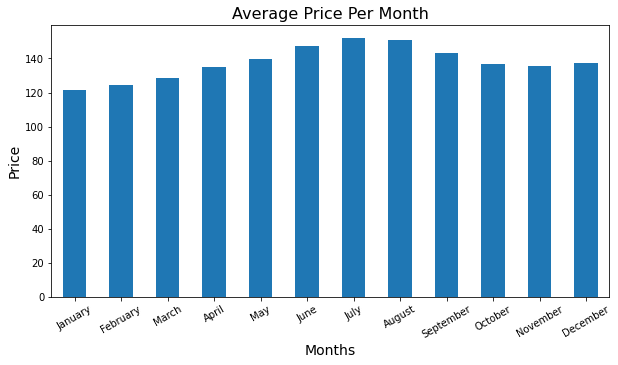

In [366]:
price_month = calendar_clean.groupby(calendar_clean.month, sort=False)['price'].mean()

plt.figure(figsize = [8, 4])

price_month.plot(kind ='bar',figsize =(10,5), color = base_color);


plt.title('Average Price Per Month')
plt.xlabel('Months');
plt.ylabel('Price');
plt.xticks(rotation=30);

> We can see the average price per month of the year 2016! Summer months tend to have high prices and month July has the highest average prices.
We can also conclude that the prices are higher in vacation/holiday periods.

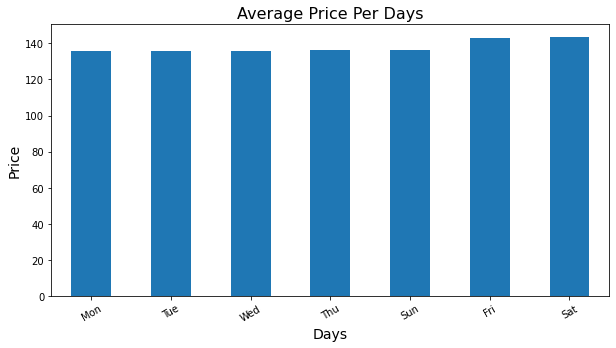

In [394]:
price_day = calendar_clean.groupby(calendar_clean.day, sort=False)['price'].mean()


price_day.plot(kind ='bar',figsize =(10,5), color = base_color);


plt.title('Average Price Per Days')
plt.xlabel('Days');
plt.ylabel('Price');
plt.xticks(rotation=30);

> We can see the average price per day of the week of the year 2016! Friday and Saturday tend to have highest average prices, which is not so suprizing.

##### 2. Which neighborhood is the most expensive one?

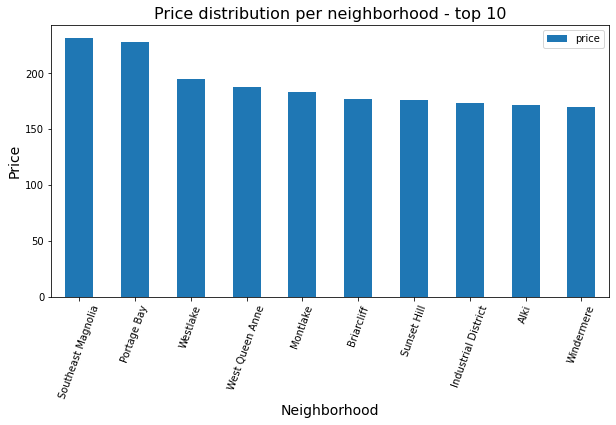

In [379]:
price_neighborhood_top_10 = listings_clean.groupby(['neighbourhood_cleansed'])[['price']].mean().sort_values(by='price',ascending=False)


price_neighborhood_top_10.head(10).plot(kind ='bar',figsize =(10,5), color = base_color);


plt.title('Price distribution per neighborhood - top 10')
plt.xlabel('Neighborhood');
plt.ylabel('Price');
plt.xticks(rotation=70);

> We can see the average price per neighborhood of top 10 most expensive neighborhoods.
Southeast Magnolia and Portage Bay are on top of the list.

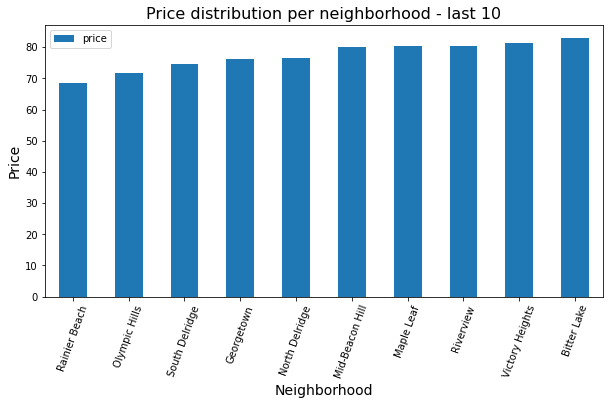

In [392]:
price_neighborhood_last_10 = listings_clean.groupby(['neighbourhood_cleansed'])[['price']].mean().sort_values(by='price',ascending=True)


price_neighborhood_last_10.head(10).plot(kind ='bar',figsize =(10,5), color = base_color);


plt.title('Price distribution per neighborhood - last 10')
plt.xlabel('Neighborhood');
plt.ylabel('Price');
plt.xticks(rotation=70);

##### 3. What property types are most popular?

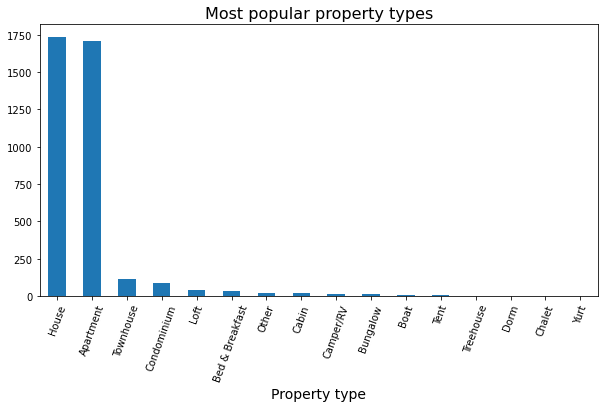

In [393]:
listings_clean['property_type'].value_counts().plot(kind = 'bar' , figsize = (10,5));

plt.title('Most popular property types')
plt.xlabel('Property type');
plt.xticks(rotation=70);

In [390]:
listings_clean['property_type'].value_counts()[0] + listings_clean['property_type'].value_counts()[1]

3441

In [391]:
3441 / listings_clean['property_type'].value_counts().sum()

0.9014933193607545

> From chart above we can see that houses and apartments are most popular property types and together they have more than 90% of the total listings.